In [42]:
%run ../initEnviroment.py
from plot_data import PlotActivity
from scipy.stats import norm, kurtosis
import os
from scipy.signal import butter, lfilter, freqz

# Data Preprocessing

## Plot activity

In [10]:
plot = PlotActivity(4,"acc") #experiment 1

<Figure size 1152x864 with 0 Axes>

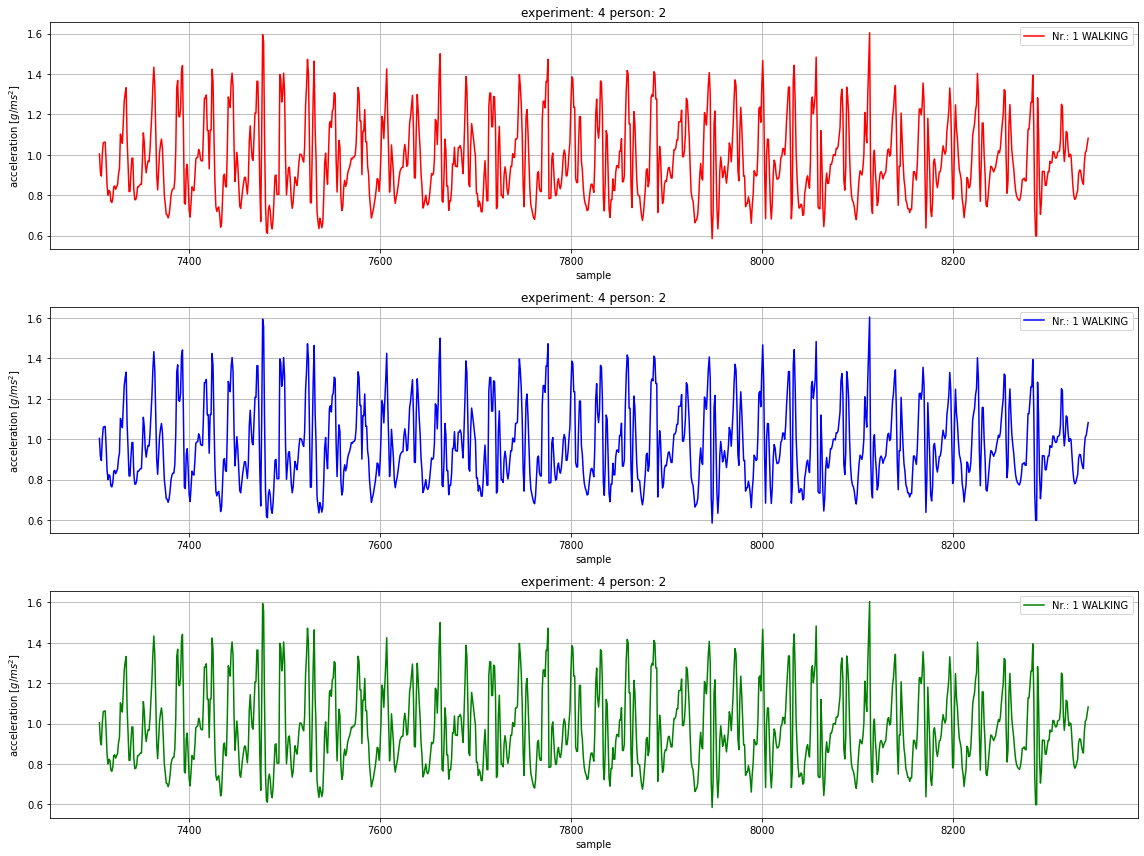

<Figure size 1152x864 with 0 Axes>

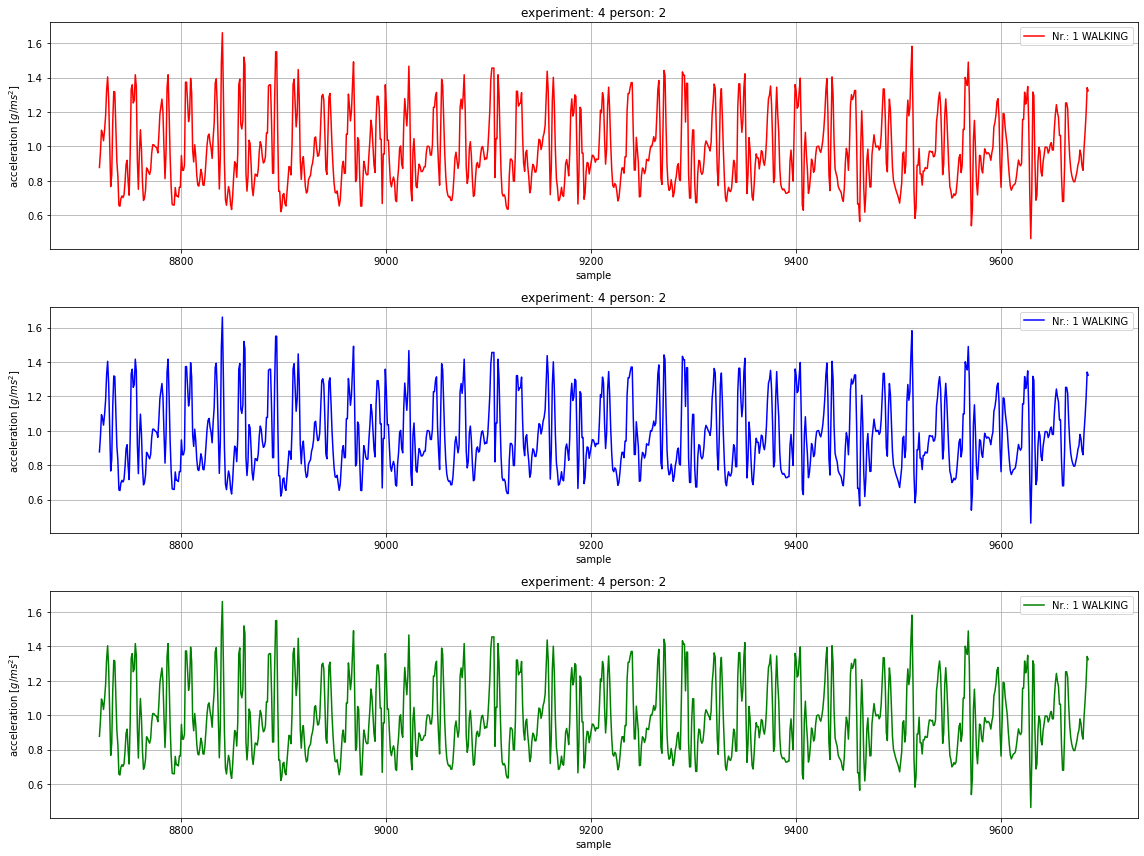

In [11]:
plot.plot_activity(1) #activity 1

## Read all data

To get an appropriate DataFrame, we need to use the `labels.txt`. In this file there are informations about the experiment, person activity and the start and end informations.

|experiment|person|activity|start|end|
|----------|------|--------|-----|---|
|Id of the experiment|Id of the person|Id of the activity|activity start|activity end|


There are 61 raw data files. In these files there are 6 signals. 3 singnals for the accelerometer (x,y,z). And 3 for the gyroscope (x,y,z).
The sample rate of the measurements is 50Hz. This means there is a data point in each 0.02 seconds. 

As before mentioned there are 61 files, but it would be better to work only with one dataframe. To do so, we can merge all of them, and than we will have a huge dataframe with all measurements.
With a mapping function it is possible to extend the data with the corresponding labels from the labels.txt.

In [15]:
labels = pd.read_csv('../data/RawData/labels.txt', sep=" ", header=None)
labels.columns = ['experiment','person','activity','start','end']

In [17]:
def read_data():
    """Read all data to a dataframe"""
    
    list_df = [] #a list to collect the dataframes
    
    for i in range(1,62):
        
        if i < 10:
            i = '0' + str(i)
        else:
            i = str(i)
            
        for j in os.listdir('../data/RawData/'):
   
            if "acc_exp" + i in j:
                acc_path = "../data/RawData/" + j
                
            elif "gyro_exp" + i in j:
                gyro_path = "../data/RawData/" + j
                    
        acc_df = pd.read_csv(acc_path, sep = " ", names=['acc_x','acc_y','acc_z'])
        gyro_df = pd.read_csv(gyro_path, sep = " ", names=['gyro_x','gyro_y','gyro_z'])
        
        exp_df = pd.concat([acc_df,gyro_df],1)
        exp_df["experiment"] = int(i) #keep track of the experiment
        
        list_df.append(exp_df)
    
    df = pd.concat(list_df)
        
    return df

In [18]:
df = read_data()

### Add labels

In [19]:
def add_activity_label(df):
    """Add activity labels form the labels dataframe"""
    
    df = df.reset_index()
    df = df.rename(columns={"index": "id"})

    df["activity"] = 0

    for index,row in labels.iterrows():

        df["activity"] = np.where((df.experiment == row["experiment"]) \
                                    & ((df.id >= row["start"]) & (df.id < row["end"])),
                                    row["activity"], df["activity"])
        
    return df

In [20]:
labeled_df = add_activity_label(df)

### Drop not activities

The measurements are continous measurements. This means, there are some part of the measurements where there is no useful data (*not labeld*). We can easily drop them.

In [21]:
def drop_unlabeled(labeled_df):
    
    """Drop unlabeld data from the original dataframe
    
    args:
        labeled_df: data frame with label features
    
    return:
        labeled_df
    """ 

    labeled_df["activity"] = np.where(labeled_df["activity"] == 0,np.NaN,labeled_df["activity"])
    labeled_df.dropna(inplace=True)
    
    labeled_df.reset_index(drop=True,inplace=True)
    
    return labeled_df

In [22]:
labeled_df = drop_unlabeled(labeled_df)

## Frequency filter 

In order to analyse only the usful part of the sensors, we need to use frequency filters. The human activities are in the low frequency range. For example the wolking is in the range of 1-3Hz [1].

The low pass filter are the appropriate tool for only use valuable range.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231187/

In [43]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

###  Test the filter

In [69]:
test_sig = labeled_df[(labeled_df["experiment"] == 1) & (labeled_df["activity"] == 4)]["acc_x"][:500]

Text(0, 0.5, 'amplitude')

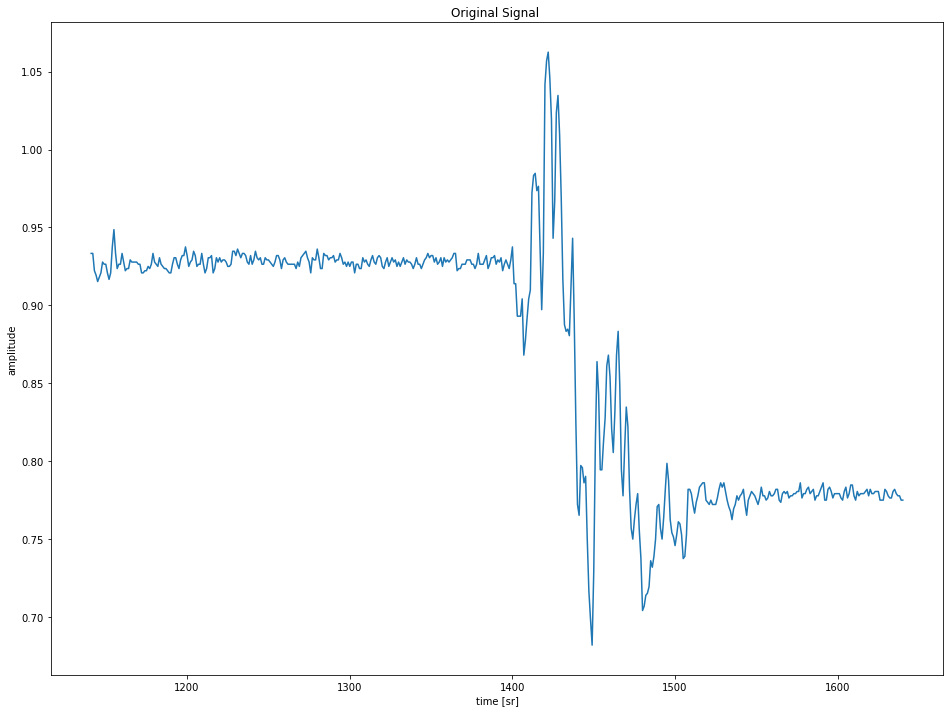

In [70]:
plt.plot(test_sig)

plt.title("Original Signal ")
plt.xlabel("time [sr]")
plt.ylabel("amplitude")

In [71]:
y_f = butter_lowpass_filter(test_sig.to_numpy(),10,50,order=2)

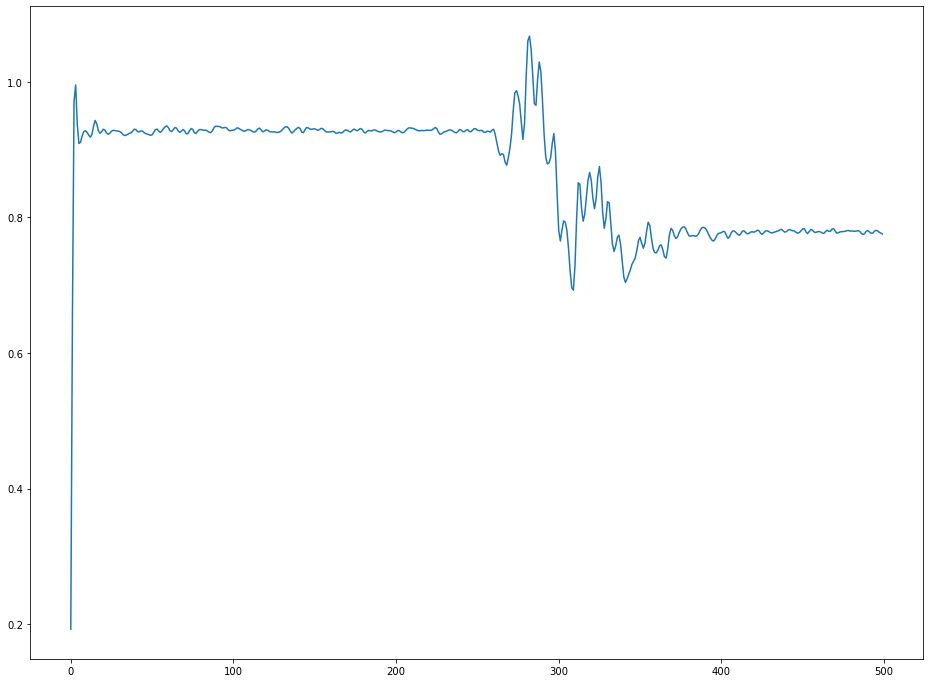

In [72]:
plt.plot(y_f)

Filter all of the the measurements.

In [26]:
def filter_acc(df, cutoff=10, fs=50, order=2):
    
    signals = ["acc_x","acc_y","acc_z"]
    
    new_df = pd.DataFrame(columns=signals)
    
    for experiment in df.experiment.unique():
    
        experiment_df = df[df.experiment == experiment]
        
        list_signals = []
        
        for j in signals:
            
            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)
            
            list_signals.append(filtered_signal)
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])
        
    return new_df


def filter_gyro(df, cutoff=10, fs=50, order=2):
    
    signals = ["gyro_x","gyro_y","gyro_z"]
    
    new_df = pd.DataFrame(columns=signals)
    
    for experiment in df.experiment.unique():
    
        experiment_df = df[df.experiment == experiment]
        
        list_signals = []
        
        for j in signals:
            
            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)
            
            list_signals.append(filtered_signal)
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])
        
    return new_df

In [27]:
filtered_df_acc = filter_acc(labeled_df,cutoff = 12)
filtered_df_gyro = filter_gyro(labeled_df,cutoff= 2)

In [28]:
labeled_df = pd.concat([labeled_df.drop(["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"],axis=1),
                       filtered_df_acc.reset_index(drop=True), filtered_df_gyro.reset_index(drop=True)],
                       axis=1)

In [29]:
labeled_df

,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,250,1,5.0,0.235200,-0.028800,0.024320,-1.759292e-05,-0.000027,0.000018
1,251,1,5.0,0.076501,-0.009250,0.006851,3.564277e-08,-0.000011,0.000037
2,252,1,5.0,0.129079,-0.015885,0.013746,7.829931e-05,0.000007,-0.000051
3,253,1,5.0,0.128992,-0.015885,0.014050,6.346766e-05,-0.000012,-0.000035
4,254,1,5.0,0.117257,-0.014997,0.012255,6.269001e-05,-0.000008,-0.000027
...,...,...,...,...,...,...,...,...,...
814395,18092,61,2.0,0.110869,-0.048672,-0.022692,6.805963e-03,0.006422,-0.001812
814396,18093,61,2.0,0.100415,-0.043688,-0.015740,6.635864e-03,0.006316,-0.002181
814397,18094,61,2.0,0.098612,-0.041690,-0.006807,6.739359e-03,0.005797,-0.002230
814398,18095,61,2.0,0.094885,-0.037474,-0.015753,6.961355e-03,0.005180,-0.001861


### Create extended df with block id

In [30]:
labeled_df.reset_index(inplace=True)

In [31]:
labeled_df = labeled_df.sort_values(["activity","index"]).reset_index(drop=True)

In [32]:
labeled_df

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,6716,7496,1,1.0,0.132204,-0.014566,-0.000090,-0.003594,0.004369,-0.000621
1,6717,7497,1,1.0,0.043589,0.004405,-0.018113,-0.006808,-0.002996,0.000826
2,6718,7498,1,1.0,0.108911,-0.018835,-0.015524,-0.007468,-0.004576,0.000587
3,6719,7499,1,1.0,0.136506,-0.049030,-0.016969,-0.006823,-0.004325,0.000149
4,6720,7500,1,1.0,0.124164,-0.055178,-0.018184,-0.004640,-0.003530,-0.000578
...,...,...,...,...,...,...,...,...,...,...
814395,807974,8666,61,12.0,0.097013,-0.034568,0.012809,-0.003197,0.006761,-0.002674
814396,807975,8667,61,12.0,0.133259,-0.042894,0.037612,-0.003615,0.006755,-0.002603
814397,807976,8668,61,12.0,0.122709,-0.037158,0.015997,-0.005337,0.006793,-0.002179
814398,807977,8669,61,12.0,0.119600,-0.035614,0.017915,-0.005619,0.004781,-0.001664


In [33]:
def create_extended_df(df, window_size, overlap):

    """Create a new df where each block get an id. The blocks are
    part of the original dataframe but each block has an overlap with the previous one."""
    
    k = 0
    overlap = 1 - overlap
    
    df["block"] = None
    df1 = pd.DataFrame()
    
    for activity in df.activity.unique():
        i = 0
        j = window_size
    
        activity_df = df[df.activity == activity]
    
        for _ in range(int(int(len(activity_df)/window_size)/overlap)):
            
            df2 = activity_df.iloc[int(i):int(j)].copy()
            df2["block"] = k

            new_df = pd.concat([df1,df2])

            df1 = new_df
            
            i += window_size*overlap
            j += window_size*overlap
            k += 1
            
    return new_df

In [34]:
block_df= create_extended_df(labeled_df,256,0.5)

In [315]:
block_df[block_df["block"] == 100]

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
25600,149767,8185,12,1.0,1.189236,-0.388871,0.114260,-0.343227,-0.088995,0.089025,100
25601,149768,8186,12,1.0,1.484033,-0.478827,0.175726,-0.284844,-0.073313,0.087949,100
25602,149769,8187,12,1.0,1.463918,-0.309280,0.156153,-0.176114,-0.024240,0.058654,100
25603,149770,8188,12,1.0,1.188741,-0.002353,0.113963,-0.062377,0.003205,0.037667,100
25604,149771,8189,12,1.0,1.098692,0.158499,0.136746,0.030275,-0.032224,0.070611,100
...,...,...,...,...,...,...,...,...,...,...,...
26107,150274,8692,12,1.0,0.952447,-0.125344,0.071573,-0.472532,0.290812,0.147627,100
26108,150275,8693,12,1.0,0.960408,-0.099982,0.085610,-0.459909,0.243163,0.171788,100
26109,150276,8694,12,1.0,0.924398,-0.067390,0.149251,-0.443072,0.215643,0.174433,100
26110,150277,8695,12,1.0,0.876493,-0.036552,0.205316,-0.419330,0.193959,0.157459,100


In [35]:
block_df

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
0,6716,7496,1,1.0,0.132204,-0.014566,-0.000090,-0.003594,0.004369,-0.000621,0
1,6717,7497,1,1.0,0.043589,0.004405,-0.018113,-0.006808,-0.002996,0.000826,0
2,6718,7498,1,1.0,0.108911,-0.018835,-0.015524,-0.007468,-0.004576,0.000587,0
3,6719,7499,1,1.0,0.136506,-0.049030,-0.016969,-0.006823,-0.004325,0.000149,0
4,6720,7500,1,1.0,0.124164,-0.055178,-0.018184,-0.004640,-0.003530,-0.000578,0
...,...,...,...,...,...,...,...,...,...,...,...
814395,807974,8666,61,12.0,0.097013,-0.034568,0.012809,-0.003197,0.006761,-0.002674,6355
814396,807975,8667,61,12.0,0.133259,-0.042894,0.037612,-0.003615,0.006755,-0.002603,6355
814397,807976,8668,61,12.0,0.122709,-0.037158,0.015997,-0.005337,0.006793,-0.002179,6355
814398,807977,8669,61,12.0,0.119600,-0.035614,0.017915,-0.005619,0.004781,-0.001664,6355


In [36]:
block_df.groupby("experiment").max()

,index,id,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
experiment,,,,,,,,,,
1,13933,17969,12.0,0.312288,0.166468,0.173989,0.013127,0.018333,0.011077,6273
2,27859,18424,12.0,0.295603,0.254564,0.104218,0.015170,0.018982,0.008286,6275
3,40837,16869,12.0,0.315860,0.210788,0.203066,0.013045,0.019821,0.013901,6276
4,52483,15273,12.0,0.351538,0.198194,0.151014,0.014658,0.031589,0.018318,6278
5,66295,20151,12.0,0.348266,0.155285,0.108659,0.013268,0.020693,0.012219,6279
...,...,...,...,...,...,...,...,...,...,...
57,757207,16995,12.0,0.286099,0.120993,0.185128,0.013408,0.020873,0.008107,6351
58,771107,17786,12.0,0.333077,0.130099,0.160923,0.019432,0.011317,0.010448,6352
59,784349,16844,12.0,0.321898,0.176424,0.136447,0.020750,0.012651,0.010732,6354


In [37]:
block_df[block_df["block"] == 2] 

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
256,6972,7752,1,1.0,0.151300,-0.020695,-0.023806,-0.006134,-0.002453,-0.003229,2
257,6973,7753,1,1.0,0.114530,-0.042791,-0.018717,-0.010433,-0.008096,-0.003187,2
258,6974,7754,1,1.0,0.112035,-0.107624,-0.044209,-0.009780,-0.013350,-0.003520,2
259,6975,7755,1,1.0,0.142041,-0.071963,-0.042157,-0.004609,-0.006175,-0.003317,2
260,6976,7756,1,1.0,0.179207,-0.095633,-0.071597,0.001769,0.008161,-0.002704,2
...,...,...,...,...,...,...,...,...,...,...,...
507,7223,8003,1,1.0,0.086525,-0.031379,0.003044,0.002361,-0.006756,0.001630,2
508,7224,8004,1,1.0,0.160387,-0.001497,-0.055968,-0.000270,-0.005658,0.002746,2
509,7225,8005,1,1.0,0.130710,-0.040074,-0.004949,-0.003112,-0.003492,0.001604,2
510,7226,8006,1,1.0,0.129678,-0.035172,-0.015425,-0.003603,-0.003873,0.000980,2


Create Safety copy

In [38]:
block_df.to_csv("../data/labeld_data_256.csv",index=True, header=True)

# Create features

### Read and clean data

In [123]:
block_df = pd.read_csv("../data/labeld_data.csv",header=0,index_col=0)

c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [39]:
block_df

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
0,6716,7496,1,1.0,0.132204,-0.014566,-0.000090,-0.003594,0.004369,-0.000621,0
1,6717,7497,1,1.0,0.043589,0.004405,-0.018113,-0.006808,-0.002996,0.000826,0
2,6718,7498,1,1.0,0.108911,-0.018835,-0.015524,-0.007468,-0.004576,0.000587,0
3,6719,7499,1,1.0,0.136506,-0.049030,-0.016969,-0.006823,-0.004325,0.000149,0
4,6720,7500,1,1.0,0.124164,-0.055178,-0.018184,-0.004640,-0.003530,-0.000578,0
...,...,...,...,...,...,...,...,...,...,...,...
814395,807974,8666,61,12.0,0.097013,-0.034568,0.012809,-0.003197,0.006761,-0.002674,6355
814396,807975,8667,61,12.0,0.133259,-0.042894,0.037612,-0.003615,0.006755,-0.002603,6355
814397,807976,8668,61,12.0,0.122709,-0.037158,0.015997,-0.005337,0.006793,-0.002179,6355
814398,807977,8669,61,12.0,0.119600,-0.035614,0.017915,-0.005619,0.004781,-0.001664,6355


### Labels for the ML model

In [40]:
activity_labels = block_df.groupby("block").mean()["activity"]

In [41]:
activity_labels

block
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
6351    12.0
6352    12.0
6353    12.0
6354    12.0
6355    12.0
Name: activity, Length: 6356, dtype: float64

In [42]:
block_df["activity"] = np.where(block_df["activity"] == 0,np.NaN,block_df["activity"])

In [43]:
block_df.dropna(inplace=True)

In [44]:
block_df.reset_index(drop=True,inplace=True)

### Creating aggregated dataframe

In [45]:
block_df

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
0,6716,7496,1,1.0,0.132204,-0.014566,-0.000090,-0.003594,0.004369,-0.000621,0
1,6717,7497,1,1.0,0.043589,0.004405,-0.018113,-0.006808,-0.002996,0.000826,0
2,6718,7498,1,1.0,0.108911,-0.018835,-0.015524,-0.007468,-0.004576,0.000587,0
3,6719,7499,1,1.0,0.136506,-0.049030,-0.016969,-0.006823,-0.004325,0.000149,0
4,6720,7500,1,1.0,0.124164,-0.055178,-0.018184,-0.004640,-0.003530,-0.000578,0
...,...,...,...,...,...,...,...,...,...,...,...
1626300,807974,8666,61,12.0,0.097013,-0.034568,0.012809,-0.003197,0.006761,-0.002674,6355
1626301,807975,8667,61,12.0,0.133259,-0.042894,0.037612,-0.003615,0.006755,-0.002603,6355
1626302,807976,8668,61,12.0,0.122709,-0.037158,0.015997,-0.005337,0.006793,-0.002179,6355
1626303,807977,8669,61,12.0,0.119600,-0.035614,0.017915,-0.005619,0.004781,-0.001664,6355


In [46]:
signals = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

In [47]:
from scipy import signal

#### Agg df with the build in statistics 

In [48]:
agg_df = block_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                   "median", "min", "max", 
                                   "std", "var", "sem", 
                                   "skew", "quantile"] for x in signals})

### Frequency analysis

In [49]:
block_df[block_df["activity"] == 1]

,index,id,experiment,activity,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,block
0,6716,7496,1,1.0,0.132204,-0.014566,-0.000090,-0.003594,0.004369,-0.000621,0
1,6717,7497,1,1.0,0.043589,0.004405,-0.018113,-0.006808,-0.002996,0.000826,0
2,6718,7498,1,1.0,0.108911,-0.018835,-0.015524,-0.007468,-0.004576,0.000587,0
3,6719,7499,1,1.0,0.136506,-0.049030,-0.016969,-0.006823,-0.004325,0.000149,0
4,6720,7500,1,1.0,0.124164,-0.055178,-0.018184,-0.004640,-0.003530,-0.000578,0
...,...,...,...,...,...,...,...,...,...,...,...
243687,810168,12192,61,1.0,0.103034,-0.000164,0.029604,-0.002982,-0.001141,-0.000354,951
243688,810169,12193,61,1.0,0.098618,0.010277,0.028975,-0.002558,-0.002215,-0.001123,951
243689,810170,12194,61,1.0,0.100997,0.004581,0.025671,-0.002493,-0.001982,-0.002095,951
243690,810171,12195,61,1.0,0.110319,-0.025638,0.037978,-0.001891,-0.000827,-0.002532,951


In [50]:
y = block_df[block_df["block"] == 2323]["acc_x"]

####  FFT with pwelch

In [73]:
x, fft = signal.welch(y, 50, nperseg=128)

In [75]:
len(x)

65

In [53]:
np.tile(x,2)

array([ 0.       ,  0.1953125,  0.390625 ,  0.5859375,  0.78125  ,
        0.9765625,  1.171875 ,  1.3671875,  1.5625   ,  1.7578125,
        1.953125 ,  2.1484375,  2.34375  ,  2.5390625,  2.734375 ,
        2.9296875,  3.125    ,  3.3203125,  3.515625 ,  3.7109375,
        3.90625  ,  4.1015625,  4.296875 ,  4.4921875,  4.6875   ,
        4.8828125,  5.078125 ,  5.2734375,  5.46875  ,  5.6640625,
        5.859375 ,  6.0546875,  6.25     ,  6.4453125,  6.640625 ,
        6.8359375,  7.03125  ,  7.2265625,  7.421875 ,  7.6171875,
        7.8125   ,  8.0078125,  8.203125 ,  8.3984375,  8.59375  ,
        8.7890625,  8.984375 ,  9.1796875,  9.375    ,  9.5703125,
        9.765625 ,  9.9609375, 10.15625  , 10.3515625, 10.546875 ,
       10.7421875, 10.9375   , 11.1328125, 11.328125 , 11.5234375,
       11.71875  , 11.9140625, 12.109375 , 12.3046875, 12.5      ,
       12.6953125, 12.890625 , 13.0859375, 13.28125  , 13.4765625,
       13.671875 , 13.8671875, 14.0625   , 14.2578125, 14.4531

In [54]:
np.full(128, 7,dtype=np.int16)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int16)

In [59]:
def do_fft(df):
    
    "Creat a new df with the frequency spectrum of each blocks"
    
    signals = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
    #df.columns = ['index', 'id', 'experiment', 'activity'] + signals + ["block"]
    
    new_df = pd.DataFrame()
    
    for block in df.block.unique():
        
        fft_df = df[df["block"] == block]
        
        list_signals = []
        
        for j in signals:
            
            freq, amp = signal.welch(fft_df[j], 50, nperseg=128)
            
            list_signals.append(amp)
            
        list_signals.append(np.full(len(freq), block))
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=[x+"_FFT" for x in signals]+["block"])])
        new_df.dropna(axis=1,inplace=True)
        
        
    #new_df["freq"] = np.tile(x,len(df.block.unique()))
    new_df["block"] = new_df["block"].astype('int32')
        
    return new_df
        

In [60]:
fft_df = do_fft(block_df)


In [72]:
fft_df[fft_df["block"] == 2321]

,acc_x_FFT,acc_y_FFT,acc_z_FFT,gyro_x_FFT,gyro_y_FFT,gyro_z_FFT,block
0,0.000001,0.000012,6.864968e-06,6.508334e-06,9.858658e-07,5.122338e-08,2321
1,0.000007,0.000026,1.247075e-05,1.375819e-05,2.274506e-06,5.810435e-07,2321
2,0.000013,0.000099,7.704886e-05,8.307146e-06,3.023151e-06,9.498349e-07,2321
3,0.000021,0.000114,5.836113e-05,2.406789e-06,1.680879e-06,6.032829e-07,2321
4,0.001217,0.000267,2.905464e-05,7.108866e-07,3.687564e-07,3.145985e-07,2321
...,...,...,...,...,...,...,...
60,0.000010,0.000012,9.168863e-06,1.233648e-09,2.461161e-09,4.158735e-10,2321
61,0.000004,0.000005,7.640165e-06,1.504607e-09,2.626685e-09,4.740831e-10,2321
62,0.000009,0.000004,6.444608e-06,5.177212e-10,5.192462e-09,2.439880e-10,2321
63,0.000005,0.000007,4.186915e-06,6.843542e-10,9.735613e-09,9.987755e-10,2321


In [79]:
fft_df.groupby("block").count()

,acc_x_FFT,acc_y_FFT,acc_z_FFT,gyro_x_FFT,gyro_y_FFT,gyro_z_FFT
block,,,,,,
0,65,65,65,65,65,65
1,65,65,65,65,65,65
2,65,65,65,65,65,65
3,65,65,65,65,65,65
4,65,65,65,65,65,65
...,...,...,...,...,...,...
6351,65,65,65,65,65,65
6352,65,65,65,65,65,65
6353,65,65,65,65,65,65


In [82]:
fft_df["freq"] = np.tile(x,len(fft_df.block.unique()))

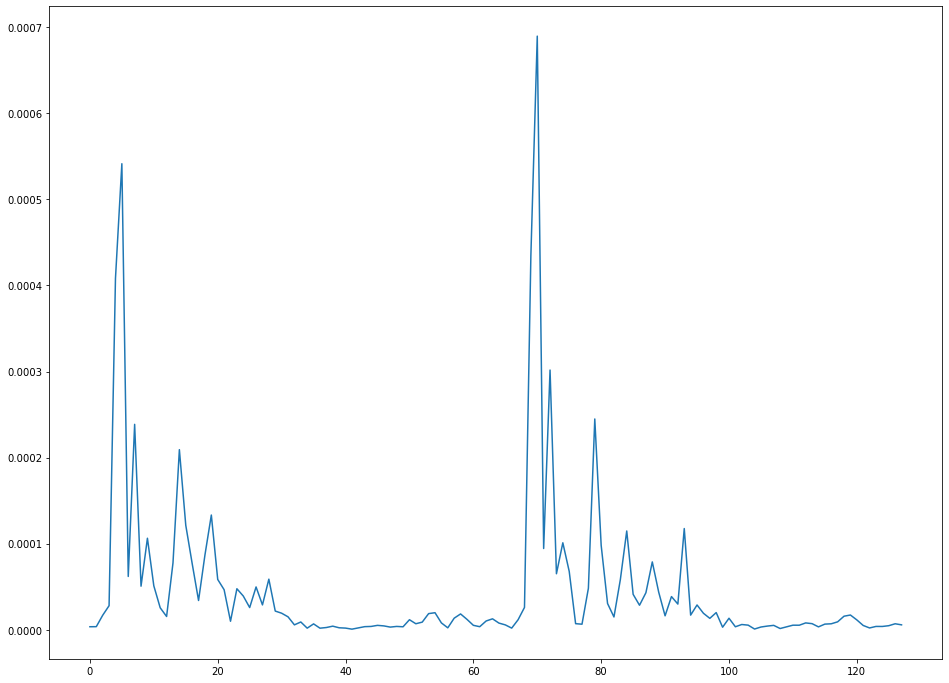

In [83]:
plt.plot(range(fft_df[0:128]["acc_x_FFT"].count()),fft_df[0:128]["acc_x_FFT"])

## Frequrncy features

### Create aggregation with normal statistic

In [84]:
fft_df.columns

Index(['acc_x_FFT', 'acc_y_FFT', 'acc_z_FFT', 'gyro_x_FFT', 'gyro_y_FFT',
       'gyro_z_FFT', 'block', 'freq'],
      dtype='object')

In [85]:
signals = ['acc_x_FFT', 'acc_y_FFT', 'acc_z_FFT', 'gyro_x_FFT', 'gyro_y_FFT','gyro_z_FFT']

In [86]:
fft_agg_df = fft_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                   "median", "min", "max", 
                                   "std", "var", "sem", 
                                   "skew", "quantile"] for x in signals})

#### Peak statistics

In [87]:
def peak_sum_all(x):
    
    peaks, _ = signal.find_peaks(x, height=0,)
    
    return sum(peaks)

def peak_mean_12(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=12:
    
        return np.mean(hight["peak_heights"][:12])

def peak_mean_8(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=8:
    
        return np.mean(hight["peak_heights"][:8])

def peak_mean_6(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=6:
    
        return np.mean(hight["peak_heights"][:6])

def peak_mean_2(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=2:
    
        return np.mean(hight["peak_heights"][:2])


In [88]:
def kurtosis_freq(x):

    return kurtosis(x, fisher=True)

def rms_10(x):
    
    y = x[:int(len(x)*0.1)]
    
    return np.sqrt(np.mean(y*2))
def rms_20(x):
    
    y = x[:int(len(x)*0.20)]
    
    return np.sqrt(np.mean(y**2))

def rms_50(x):
    
    y = x[:int(len(x)*0.50)]
    
    return np.sqrt(np.mean(y**2))

def rms_80(x):
    
    y = x[:int(len(x)*0.80)]
    
    return np.sqrt(np.mean(y**2))

def rms_100(x):

    return np.sqrt(np.mean(y**2)) 

def band_amp_1():
    pass

def band_amp_2():
    pass

def band_amp_3():
    pass

def band_amp_4():
    pass

In [89]:
fft_agg_df = fft_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                              "median", "min", "max", 
                                              "std", "var", "sem", 
                                              "skew", "quantile",
                                              peak_sum_all, kurtosis_freq, peak_mean_2,
                                              peak_mean_6, peak_mean_8, peak_mean_12,
                                              rms_10, rms_20, rms_50,
                                              rms_80, rms_100] for x in signals })

In [54]:
fft_agg_df

acc_x_FFT                                                        \
            sum      mean       mad    median           min       max   
block                                                                   
0      0.331513  0.002570  0.003887  0.000058  3.286885e-13  0.087807   
1      0.275338  0.002134  0.003187  0.000030  4.160845e-14  0.067522   
2      0.298804  0.002316  0.003379  0.000072  4.591874e-14  0.073211   
3      0.363132  0.002815  0.004259  0.000098  4.207670e-13  0.081494   
4      0.298854  0.002317  0.003278  0.000074  1.398344e-13  0.057493   
...         ...       ...       ...       ...           ...       ...   
3169   0.930020  0.007209  0.012336  0.000160  4.328119e-05  0.417819   
3170   0.718205  0.005567  0.009651  0.000143  2.536263e-05  0.297028   
3171   0.842571  0.006532  0.011631  0.000104  2.003945e-05  0.357560   
3172   0.918159  0.007118  0.011817  0.000127  3.694205e-05  0.342541   
3173   1.077721  0.008354  0.014628  0.000104  3.138433e-05  0.484983   

                                               ...    gyro_z_FFT              \
            std       var       sem      skew  ... kurtosis_freq peak_mean_2   
block                                          ...                             
0      0.010057  0.000101  0.000885  6.601805  ...     33.061341    0.041734   
1      0.007382  0.000054  0.000650  6.536404  ...     28.900984    0.036947   
2      0.008523  0.000073  0.000750  6.556131  ...     35.909406    0.036832   
3      0.010605  0.000112  0.000934  6.051769  ...     39.497501    0.049073   
4      0.006415  0.000041  0.000565  5.794714  ...     24.003735    0.043706   
...         ...       ...       ...       ...  ...           ...         ...   
3169   0.042481  0.001805  0.003740  8.239326  ...     69.772727    0.340757   
3170   0.033522  0.001124  0.002951  7.757655  ...     56.476119    0.226190   
3171   0.040506  0.001641  0.003566  7.680926  ...     59.989528    0.274586   
3172   0.039344  0.001548  0.003464  7.605027  ...     56.839389    0.287497   
3173   0.052075  0.002712  0.004585  7.966450  ...     54.646118    0.372721   

                                                                          \
      peak_mean_6 peak_mean_8 peak_mean_12    rms_10    rms_20    rms_50   
block                                                                      
0        0.018675    0.014039     0.009375  0.156632  0.015637  0.009773   
1        0.016761    0.012580     0.008389  0.165748  0.016119  0.010074   
2        0.015884    0.011924     0.007951  0.158913  0.015205  0.009503   
3        0.020868    0.015674     0.010451  0.162370  0.017867  0.011167   
4        0.019063    0.014324     0.009554  0.166331  0.016599  0.010375   
...           ...         ...          ...       ...       ...       ...   
3169     0.117793    0.088382     0.058943  0.457695  0.146801  0.091751   
3170     0.075666    0.056755     0.037840  0.420789  0.115619  0.072262   
3171     0.092025    0.069033     0.046029  0.437660  0.136922  0.085576   
3172     0.099799    0.074858          NaN  0.476297  0.145082  0.090676   
3173     0.134956    0.101232     0.067494  0.525503  0.177121  0.110701   

                           
         rms_80   rms_100  
block                      
0      0.007704  1.020964  
1      0.007941  1.020964  
2      0.007491  1.020964  
3      0.008803  1.020964  
4      0.008178  1.020964  
...         ...       ...  
3169   0.072324  1.020964  
3170   0.056961  1.020964  
3171   0.067457  1.020964  
3172   0.071477  1.020964  
3173   0.087261  1.020964  

[3174 rows x 132 columns]

In [254]:
x, fft = signal.welch(y, 50, nperseg=256)

In [255]:
peaks, _ = signal.find_peaks(fft, height=0,)

In [256]:
peaks

array([  2,   4,   8,  14,  18,  24,  30,  33,  40,  45,  50,  58,  64,
        68,  71,  76,  80,  85,  87,  91,  96, 100, 107, 111, 113],
      dtype=int64)

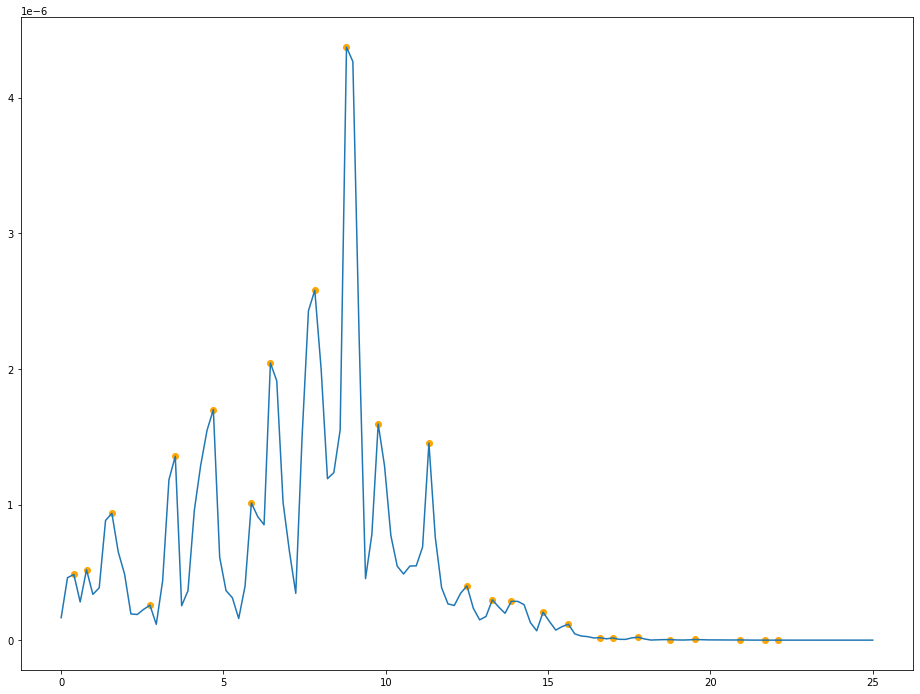

In [228]:
plt.plot(x,fft)
plt.scatter(x = x[peaks],y=_["peak_heights"], c="orange")

## Merge time and frequency domain

In [90]:
features = agg_df.merge(fft_agg_df,on="block")

## ML Prototype

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [92]:
X_train, X_test, y_train, y_test = train_test_split(features, activity_labels,random_state=42, test_size = 0.3)



pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                 ('scaler', StandardScaler()), ('svc', SVC())])

In [93]:
parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 3e-4],
                     'svc__C': [1, 10, 100, 200, 400, 600, 1000]},
              {'svc__kernel': ['linear'], 'svc__C': [x for x in range(5,15)]},
              {'svc__kernel': ['poly'], 'svc__degree': [x for x in range(2,7)],
                     'svc__C': [x for x in range(5,15)]}]

search = GridSearchCV(pipe, param_grid=parameters)

In [94]:
search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [1, 10, 100, 200, 400, 600, 1000],
                          'svc__gamma': [0.001, 0.0003],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                          'svc__kernel': ['linear']},
                         {'svc__C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                          'svc__degree': [2, 3, 4, 5, 6],
                          'svc__kernel': ['poly']}])

In [95]:
accuracy_score(y_test,search.predict(X_test))

0.9737808075511274

In [96]:
search.best_params_

{'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

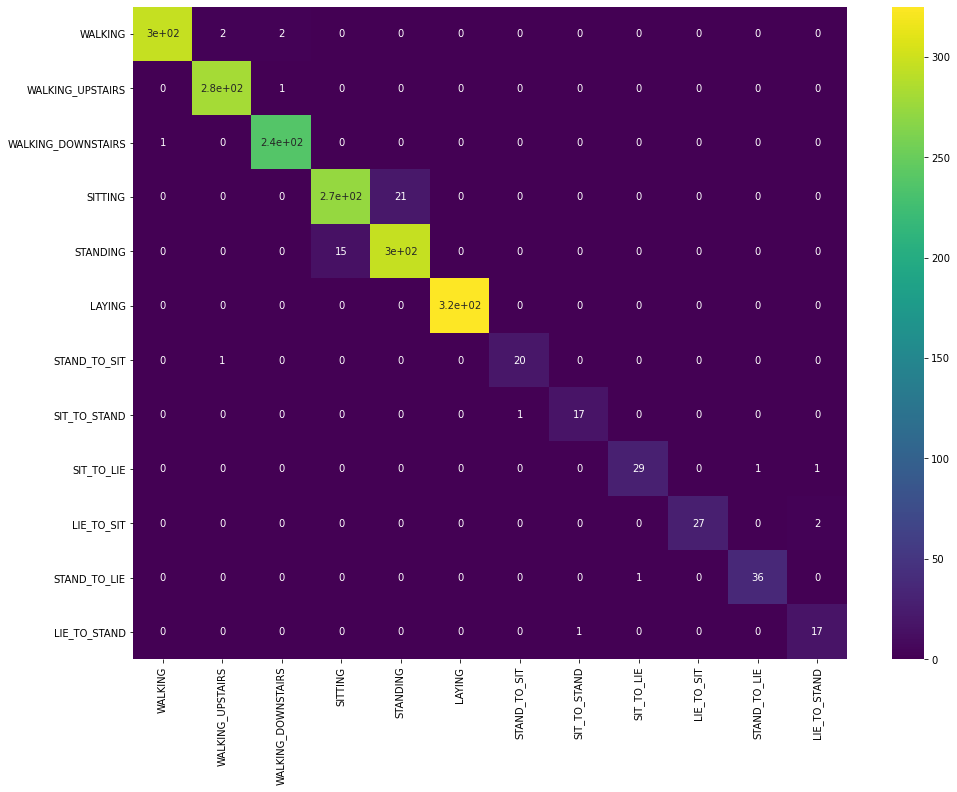

In [97]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,search.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])


In [195]:
scores = cross_vals_score(search, X_train, y_train, cv=5)

In [196]:
scores

array([0.96629213, 0.96846847, 0.97297297, 0.95945946, 0.96846847])